In [2]:
# 📊 Stock Price Prediction: Comparing Random Forest, XGBoost, and LSTM

# This notebook showcases a comparison of three popular models —
#Random Forest, XGBoost, and LSTM — for predicting stock closing prices.
#It includes preprocessing, training, hyperparameter tuning, and performance evaluation.

In [3]:
## 1. 📥 Load and Prepare Data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
# Load Data
stock_data = pd.read_csv("AAPL_sample_data.csv", parse_dates=['Date'], index_col='Date')
stock_data = stock_data[['Close']].dropna()

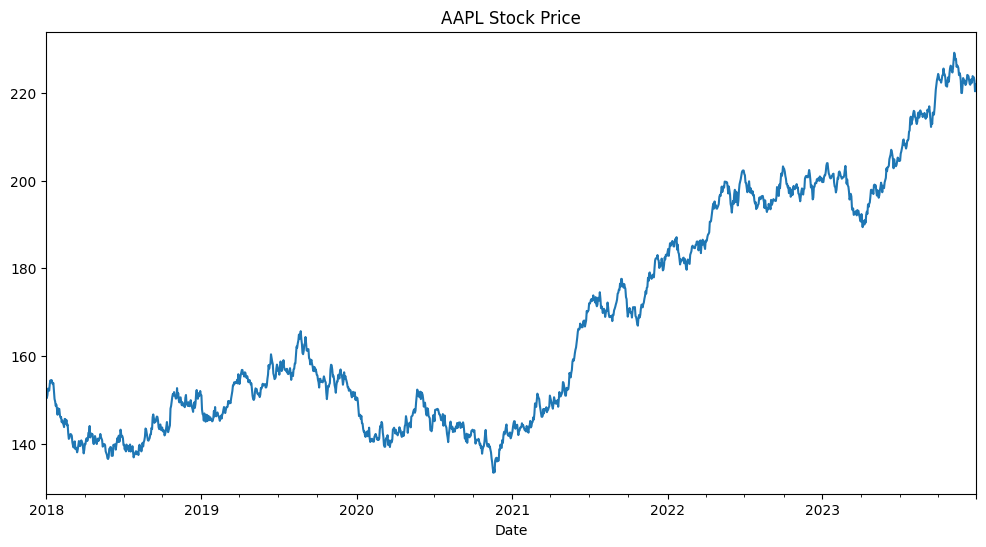

In [5]:
import matplotlib.pyplot as plt

stock_data['Close'].plot(figsize=(12,6), title='AAPL Stock Price')
plt.show()

In [6]:
## 2. 🔄 Feature Engineering
stock_data['Close_t-1'] = stock_data['Close'].shift(1)
stock_data['Close_t-2'] = stock_data['Close'].shift(2)
stock_data.dropna(inplace=True)

In [7]:
## 3. ✂️ Train-Test Split
features = ['Close_t-1', 'Close_t-2']
X = stock_data[features]
y = stock_data['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

In [8]:
## 4. 🌲 Random Forest Regressor with Tuning
rf = RandomForestRegressor()
rf_params = {'n_estimators': [100, 200], 'max_depth': [3, 5]}
rf_cv = GridSearchCV(rf, rf_params, cv=3)
rf_cv.fit(X_train, y_train)
rf_best = rf_cv.best_estimator_
rf_preds = rf_best.predict(X_test)

In [9]:
## 5. 🚀 XGBoost Regressor with Tuning
xgb = XGBRegressor(objective='reg:squarederror')
xgb_params = {'n_estimators': [100, 200], 'max_depth': [3, 5]}
xgb_cv = GridSearchCV(xgb, xgb_params, cv=3)
xgb_cv.fit(X_train, y_train)
xgb_best = xgb_cv.best_estimator_
xgb_preds = xgb_best.predict(X_test)

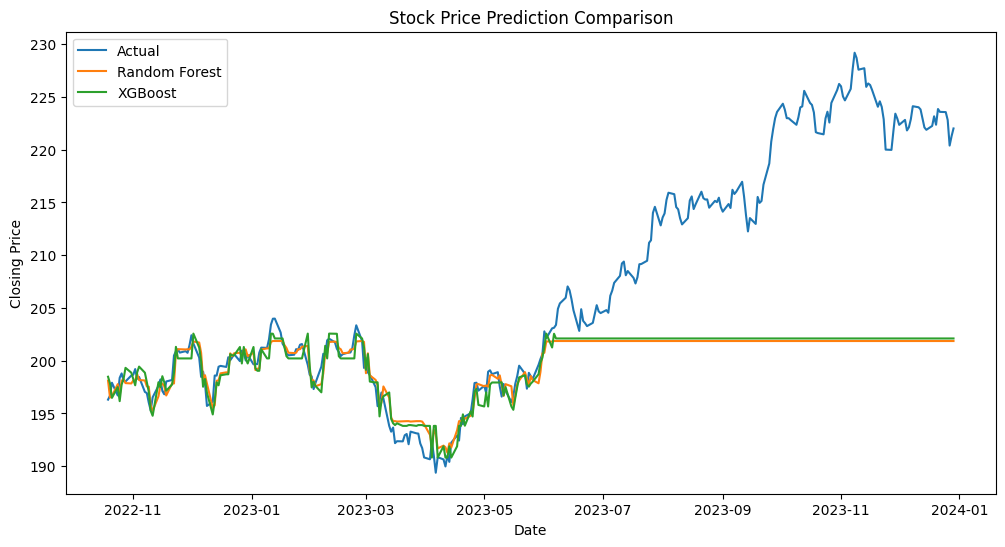

In [10]:
# 6. 📈 Visualize Predictions
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual')
plt.plot(y_test.index, rf_preds, label='Random Forest')
plt.plot(y_test.index, xgb_preds, label='XGBoost')
plt.legend()
plt.title('Stock Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()


In [11]:
## 6. 📈 LSTM with Hyperparameter Tuning
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from sklearn.model_selection import ParameterGrid

scaler = MinMaxScaler()
scaled = scaler.fit_transform(stock_data[['Close']])

def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X_lstm, y_lstm = create_sequences(scaled)
X_lstm = X_lstm.reshape((X_lstm.shape[0], X_lstm.shape[1], 1))
split = int(0.8 * len(X_lstm))
X_train_lstm, X_test_lstm = X_lstm[:split], X_lstm[split:]
y_train_lstm, y_test_lstm = y_lstm[:split], y_lstm[split:]

param_grid = {'units': [50], 'dropout': [0.2], 'batch_size': [32], 'epochs': [30]}
best_val_loss = np.inf
best_model = None

for params in ParameterGrid(param_grid):
    K.clear_session()
    model = Sequential([
        LSTM(params['units'], return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
        Dropout(params['dropout']),
        LSTM(params['units']),
        Dropout(params['dropout']),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    es = EarlyStopping(patience=5, restore_best_weights=True)
    model.fit(X_train_lstm, y_train_lstm, epochs=params['epochs'],
              batch_size=params['batch_size'], validation_data=(X_test_lstm, y_test_lstm),
              callbacks=[es], verbose=0)

    val_loss = model.evaluate(X_test_lstm, y_test_lstm, verbose=0)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = model

lstm_preds = best_model.predict(X_test_lstm)
lstm_preds_inverse = scaler.inverse_transform(lstm_preds.reshape(-1, 1))
y_test_lstm_inverse = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [12]:
## 7. 🧪 Performance Evaluation
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
lstm_rmse = np.sqrt(mean_squared_error(y_test_lstm_inverse, lstm_preds_inverse))

rf_mae = mean_absolute_error(y_test, rf_preds)
xgb_mae = mean_absolute_error(y_test, xgb_preds)
lstm_mae = mean_absolute_error(y_test_lstm_inverse, lstm_preds_inverse)

print("\n📊 Model Performance:")
print(f"Random Forest - RMSE: {rf_rmse:.2f}, MAE: {rf_mae:.2f}")
print(f"XGBoost        - RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}")
print(f"LSTM           - RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}")


📊 Model Performance:
Random Forest - RMSE: 11.53, MAE: 7.61
XGBoost        - RMSE: 11.38, MAE: 7.57
LSTM           - RMSE: 2.39, MAE: 1.85


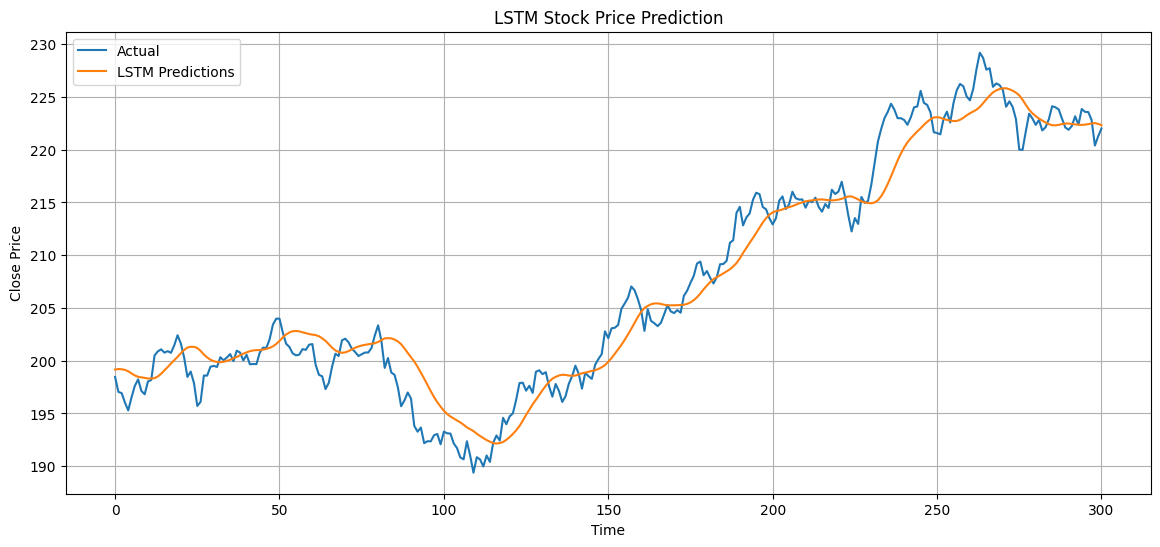

In [13]:
## 8. 📊 Visualization
plt.figure(figsize=(14, 6))
plt.plot(y_test_lstm_inverse, label='Actual')
plt.plot(lstm_preds_inverse, label='LSTM Predictions')
plt.title("LSTM Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

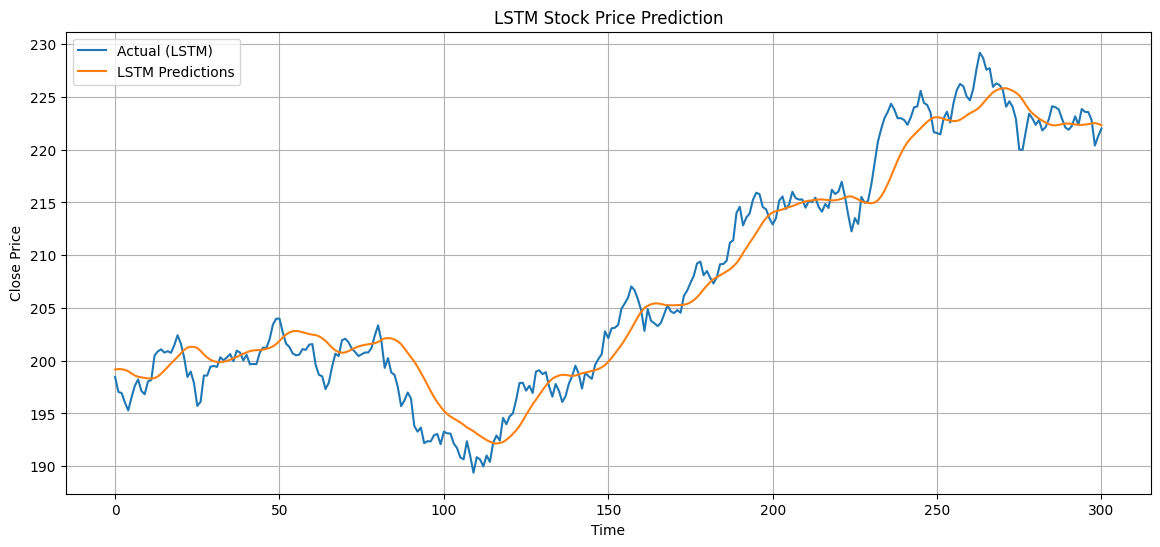

In [14]:
# LSTM Prediction vs Actual
plt.figure(figsize=(14, 6))
plt.plot(y_test_lstm_inverse, label='Actual (LSTM)')
plt.plot(lstm_preds_inverse, label='LSTM Predictions')
plt.title("LSTM Stock Price Prediction")
plt.xlabel("Time")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()

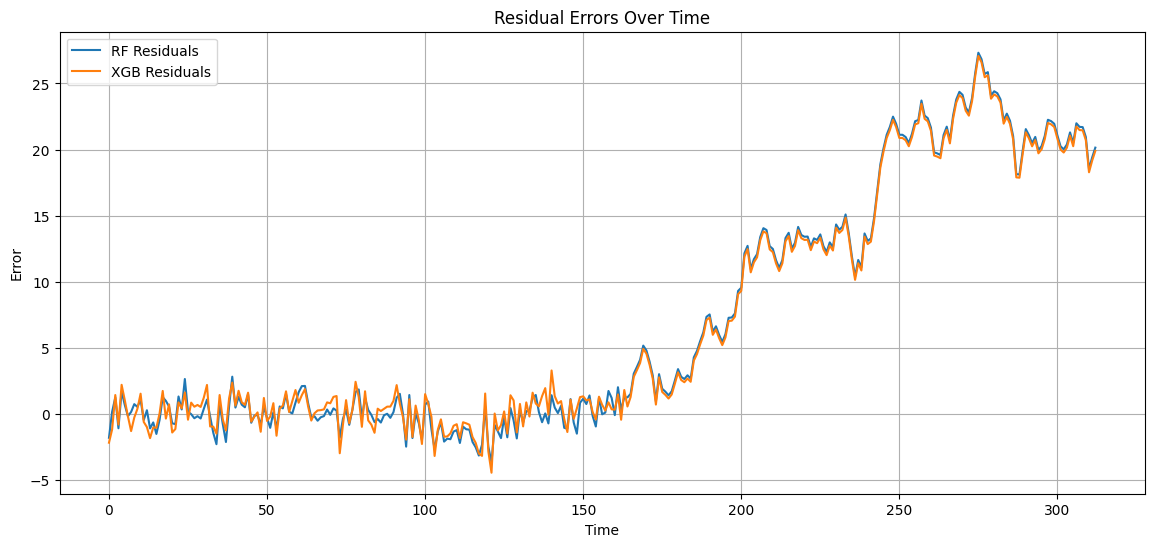

In [15]:
# Residual Plots
plt.figure(figsize=(14, 6))
plt.plot(y_test.values - rf_preds, label='RF Residuals')
plt.plot(y_test.values - xgb_preds, label='XGB Residuals')
plt.title("Residual Errors Over Time")
plt.xlabel("Time")
plt.ylabel("Error")
plt.legend()
plt.grid(True)
plt.show()

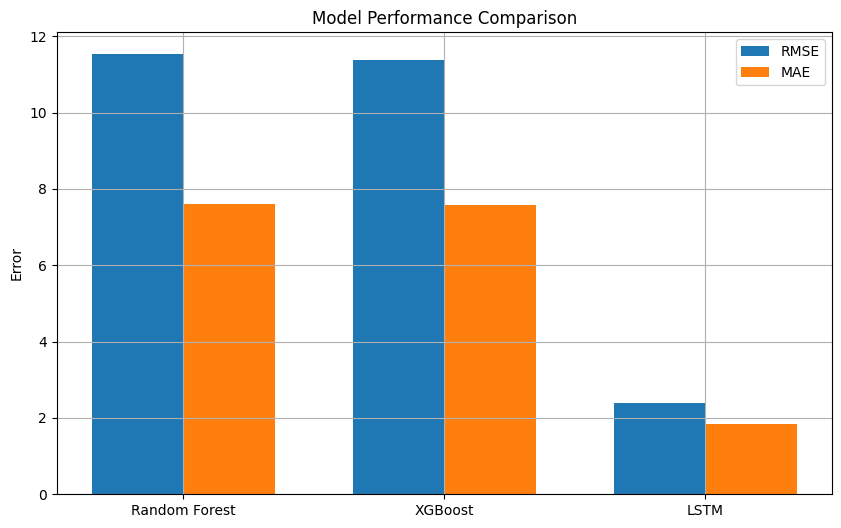

In [16]:
# Bar Chart for RMSE and MAE
labels = ['Random Forest', 'XGBoost', 'LSTM']
rmse_scores = [rf_rmse, xgb_rmse, lstm_rmse]
mae_scores = [rf_mae, xgb_mae, lstm_mae]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, rmse_scores, width, label='RMSE')
ax.bar(x + width/2, mae_scores, width, label='MAE')

ax.set_ylabel('Error')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
plt.grid(True)
plt.show()

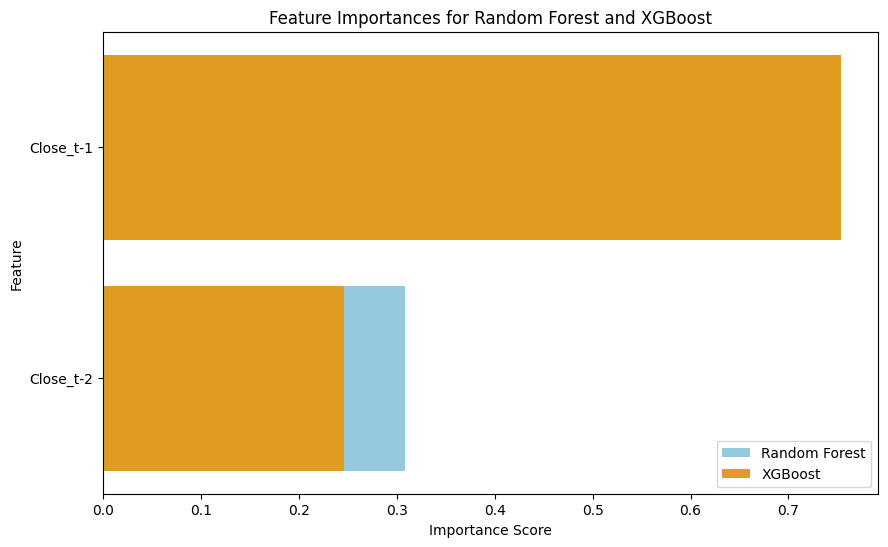

In [17]:
# prompt: feature importance for all models

# Feature Importance for Random Forest and XGBoost
importances_rf = rf_best.feature_importances_
importances_xgb = xgb_best.feature_importances_

feature_names = features

# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Random Forest': importances_rf, 'XGBoost': importances_xgb})

# Plotting Feature Importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Random Forest', y='Feature', data=importance_df, color='skyblue', label='Random Forest')
sns.barplot(x='XGBoost', y='Feature', data=importance_df, color='orange', label='XGBoost')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances for Random Forest and XGBoost')
plt.legend()
plt.show()


In [18]:
# prompt: accuracy and best model

print("\n📊 Model Performance:")
print(f"Random Forest - RMSE: {rf_rmse:.2f}, MAE: {rf_mae:.2f}")
print(f"XGBoost        - RMSE: {xgb_rmse:.2f}, MAE: {xgb_mae:.2f}")
print(f"LSTM           - RMSE: {lstm_rmse:.2f}, MAE: {lstm_mae:.2f}")

# Determine the best model based on RMSE (lower is better)
models = {
    'Random Forest': rf_rmse,
    'XGBoost': xgb_rmse,
    'LSTM': lstm_rmse
}
best_model_name = min(models, key=models.get)
best_rmse = models[best_model_name]

print(f"\nThe best model is {best_model_name} with an RMSE of {best_rmse:.2f}")



📊 Model Performance:
Random Forest - RMSE: 11.53, MAE: 7.61
XGBoost        - RMSE: 11.38, MAE: 7.57
LSTM           - RMSE: 2.39, MAE: 1.85

The best model is LSTM with an RMSE of 2.39


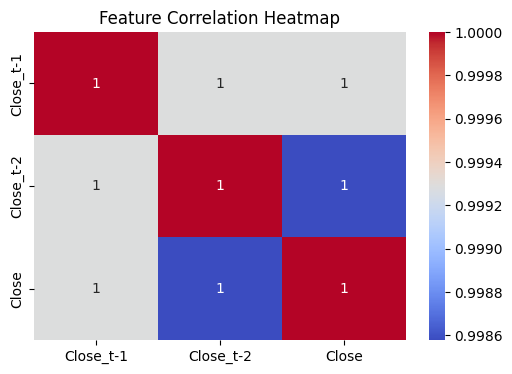

In [19]:
# Heatmap of Feature Correlation
plt.figure(figsize=(6, 4))
sns.heatmap(stock_data[features + ['Close']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [20]:
## ✅ Summary Table
# Create a DataFrame for summary
results_df = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'LSTM'],
    'RMSE': [rf_rmse, xgb_rmse, lstm_rmse],
    'MAE': [rf_mae, xgb_mae, lstm_mae]
})

# Round values and display as table
print("✅ Summary Table:")
display(results_df.round(2))


#This comparison allows you to analyze how classical machine learning and deep learning models perform on time series stock price prediction.

✅ Summary Table:


,Model,RMSE,MAE
0,Random Forest,11.53,7.61
1,XGBoost,11.38,7.57
2,LSTM,2.39,1.85
